# Völuspá analysis

The aim of this notebook is to see how the use of NLP techniques may help philological studies. My first analysis is on Völuspá (*Prophecy of the Seeress*), the first poem of the Elder Edda, telling the destiny of the worlds: from its creation to its end.

## Contents

* Download used corpora
* Read them
* Retrieve the original structure
* Syllabification
* Transcribe phonetically the text
* Alliteration
* Vocabulary
* Frequency
* Poetry


### All imports

In [1]:
import os
module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
import re
import sys
sys.path.append(module_path)
from collections import Counter

from cltk.corpus.utils.importer import CorpusImporter
from cltk.corpus.old_norse.syllabifier import hierarchy
from cltk.phonology import utils as phu
from cltk.phonology.old_norse import transcription as ont 
from cltk.utils.frequency import Frequency
from cltk.tag.pos import POSTag
from cltk.prosody.old_norse.verse import VerseManager, Fornyrdhislag, Ljoodhhaattr, ShortLine, LongLine

from old_norse.text.old_norse_texts_heimskringla import text_manager
from old_norse.text.old_norse_texts_heimskringla import reader as heim_reader
#from syllabified_text_reader import read_annotated_text

from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

### Download Old Norse Corpora to cltk_data directory

In [2]:
onc = CorpusImporter("old_norse")
onc.import_corpus("old_norse_texts_heimskringla")
onc.import_corpus('old_norse_models_cltk')
heim_reader.__file__

'/home/pi/cltk_data/old_norse/text/old_norse_texts_heimskringla/reader.py'

Configure **ipython**.

```bash
$ ipython profile create
$ ipython locate
$ nano .ipython/profile_default/ipython_config.py
```
 Add it a the end of the file:
```bash
c.InteractiveShellApp.exec_lines = [
    'import sys; import os; sys.path.append(os.path.join(os.environ["HOME"], "cltk_data"))',
    'import sys; import os; sys.path.append(os.path.join(os.environ["HOME"], "cltk_data", "text", "old_norse_texts_heimskringla"))'
]
```
It is necessary to do that because it makes things easier to utilize data furnished by CLTK. You will see later in the notebook how it is used.

Install the **kernel** associated with **python3.6** [https://ipython.readthedocs.io/en/stable/install/kernel_install.html](https://ipython.readthedocs.io/en/stable/install/kernel_install.html) 

In [3]:
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Völuspá"), "txt")
text = loader.load()
print(text[:200])

1.
Hljóðs bið ek allar
helgar kindir,
meiri ok minni
mögu Heimdallar;
viltu at ek, Valföðr,
vel fyr telja
forn spjöll fira,
þau er fremst of man.
 
2.
Ek man jötna
ár of borna,
þá er forðum mik
fædda 


### Split text in paragraphs ans verses
Extract the organisation of verses in Völuspá

In [4]:
# The following function is useful to improve existing functions

def remove_punctuations(text):
    res = text
    # for punctuation in "-:?":
    #    res = "".join(res.split(punctuation))
    res = re.sub("[\-:\?;,]", "", res)
    res = re.sub("z", "s", res)
    res = re.sub("x", "ks", res)
    res = re.sub(r" +", " ", res)
    return res

  * Get the indices of paragraphs delimiters
  * Extract the content between two following delimiters and seperate lines and put them in a list
  * Clean all the lines/verses

In [5]:
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text)]  #re.findall(r"[0-9]{1,2}\.", text)
paragraphs = [text[indices[i][1]:indices[i+1][0]].split("\n") for i in range(len(indices)-1)]
paragraphs = [[remove_punctuations(verse).strip() for verse in paragraph if remove_punctuations(verse) != "" and verse != "\xa0"] for paragraph in paragraphs ]
paragraphs[:3]

[['Hljóðs bið ek allar',
  'helgar kindir',
  'meiri ok minni',
  'mögu Heimdallar',
  'viltu at ek Valföðr',
  'vel fyr telja',
  'forn spjöll fira',
  'þau er fremst of man.'],
 ['Ek man jötna',
  'ár of borna',
  'þá er forðum mik',
  'fædda höfðu',
  'níu man ek heima',
  'níu íviðjur',
  'mjötvið mæran',
  'fyr mold neðan.'],
 ['Ár var alda',
  'þat er ekki var',
  'vara sandr né sær',
  'né svalar unnir',
  'jörð fannsk æva',
  'né upphiminn',
  'gap var ginnunga',
  'en gras hvergi.']]

### Syllabification in Old Norse and The *Völuspá*

Syllabification in Old Norse is a tough task and agreement among scholars has not been reached. Although Icelandic syllabifiers exist, they are not very useful because, *til dæmis* (for example), Modern Icelandic has included many [epenthetic](https://en.wikipedia.org/wiki/Epenthesis) vowels (compare *maðr* in Old Norse and *maður* in Modern Icelandic).

As a substantial example, I annotated syllables in the *Völuspá*. The code below shows how to retrieve it. Before it, I explain how the raw annotated text looks like.

#### Guidelines for syllable annotation

* \n+\n delimits lines (verses)
* \n-\n delimits words
* just \n delimits two syllables of a same word
* numbers delimit stanzas



You can see below the raw annotations.

In [6]:
with open(os.path.join(module_path, "Sæmundar-Edda/Völuspá/txt_files/syllabified/syllabified_text_complete.txt"), "r") as f:
    text = f.read()
print(text[:60])



+
-
1
+
-
Hljóðs
-
bið
-
ek
-
al
lar
+
-
hel
gar
-
kin
dir


In [7]:
pesr = heim_reader.PoeticEddaSyllabifiedReader("Völuspá")
print(pesr.raw()[:75])



Hljóðs/Hljóðs bið/bið ek/ek allar/al+lar 
helgar/hel+gar kindir/kin+dir 



Once parsed, the text is a list of paragraphs. Each paragraph is a list of verses. Each verse is a list of word. Each word is a list of syllables.

In [8]:
#from old_norse.text.old_norse_texts_heimskringla import *
syllabified_voluspa = heim_reader.PoeticEddaSyllabifiedReader.read_annotated_text(os.path.join(module_path, "Sæmundar-Edda/Völuspá/txt_files/syllabified/syllabified_text_complete.txt"))
syllabified_voluspa[:2]

[[[['Hljóðs'], ['bið'], ['ek'], ['al', 'lar']],
  [['hel', 'gar'], ['kin', 'dir']],
  [['mei', 'ri'], ['ok'], ['min', 'ni']],
  [['mö', 'gu'], ['Heim', 'dal', 'lar']],
  [['vi', 'ltu'], ['at'], ['ek'], ['Val', 'föðr']],
  [['vel'], ['fyr'], ['tel', 'ja']],
  [['forn'], ['spjöll'], ['fi', 'ra']],
  [['þau'], ['er'], ['fremst'], ['of'], ['man']]],
 [[['Ek'], ['man'], ['jö', 'tna']],
  [['ár'], ['of'], ['bor', 'na']],
  [['þá'], ['er'], ['for', 'ðum'], ['mik']],
  [['fæd', 'da'], ['höf', 'ðu']],
  [['níu'], ['man'], ['ek'], ['hei', 'ma']],
  [['níu'], ['í', 'við', 'jur']],
  [['mjöt', 'við'], ['mæ', 'ran']],
  [['fyr'], ['mold'], ['ne', 'ðan']]]]

#### Use the phonology module to transcribe phonetically the text

In [9]:
tr = phu.Transcriber(ont.DIPHTHONGS_IPA, ont.DIPHTHONGS_IPA_class, ont.IPA_class, ont.old_norse_rules)
for paragraph in paragraphs[:3]:
    for verse in paragraph:
        print(repr(verse)+"\t\t->\t"+tr.main(verse))

'Hljóðs bið ek allar'		->	[hljoːðs bið ɛk alːar]
'helgar kindir'		->	[hɛlɣar kindir]
'meiri ok minni'		->	[mɛiri ɔk minːi]
'mögu Heimdallar'		->	[mœɣu hɛimdalːar]
'viltu at ek Valföðr'		->	[viltu at ɛk valvœðr]
'vel fyr telja'		->	[vɛl fyr tɛlja]
'forn spjöll fira'		->	[fɔrn spjœlː fira]
'þau er fremst of man.'		->	[θɒu ɛr frɛmst ɔv man]
'Ek man jötna'		->	[ɛk man jœtna]
'ár of borna'		->	[aːr ɔv bɔrna]
'þá er forðum mik'		->	[θaː ɛr fɔrðum mik]
'fædda höfðu'		->	[fɛːdːa hœvðu]
'níu man ek heima'		->	[niːu man ɛk hɛima]
'níu íviðjur'		->	[niːu iːviðjur]
'mjötvið mæran'		->	[mjœtvið mɛːran]
'fyr mold neðan.'		->	[fyr mɔld nɛðan]
'Ár var alda'		->	[aːr var alda]
'þat er ekki var'		->	[θat ɛr ɛkːi var]
'vara sandr né sær'		->	[vara sandr neː sɛːr]
'né svalar unnir'		->	[neː svalar unːir]
'jörð fannsk æva'		->	[jœrð fanːsk ɛːva]
'né upphiminn'		->	[neː upːhiminː]
'gap var ginnunga'		->	[gap var ginːunɣa]
'en gras hvergi.'		->	[ɛn gras hvɛrɣi]


### Show alliterations in the text
Alliterations are the main stylistic literary device in Old Norse poetry.

In [10]:
unigram_sounds = []
bigram_sounds = []
for paragraph in paragraphs:
    for verse in paragraph:
        ipa_verse = tr.main(verse)
        ipa_verse = re.sub(r"[ \[\]]", "", ipa_verse)
        unigram_sounds.append(ipa_verse)
        bigram_sounds.extend([ipa_verse[i:i+2] for i in range(1, len(ipa_verse)-1) if " " not in ipa_verse[i:i+2]])
        
print(Counter("".join(unigram_sounds)))
print(Counter(bigram_sounds))

Counter({'r': 711, 'a': 708, 'ː': 689, 'i': 578, 'n': 464, 'ɛ': 386, 'l': 313, 's': 310, 'u': 305, 'v': 288, 't': 251, 'm': 239, 'ð': 218, 'k': 208, 'h': 173, 'ɔ': 170, 'ɣ': 154, 'œ': 143, 'd': 134, 'f': 111, 'j': 110, 'g': 108, 'o': 91, 'θ': 88, 'y': 73, 'b': 67, 'e': 39, 'p': 32, 'ɒ': 30, 'ɐ': 13})
Counter({'ar': 127, 'aː': 106, 'nː': 99, 'in': 97, 'ːr': 88, 'va': 84, 'oː': 83, 'an': 81, 'ir': 78, 'al': 77, 'ɛi': 70, 'ra': 69, 'iː': 69, 'lː': 59, 'ːð': 58, 'nd': 56, 'ɛː': 56, 'ɛr': 55, 'rɛ': 54, 'ːi': 53, 'ri': 52, 'na': 52, 'un': 50, 'ða': 49, 'um': 48, 'vɛ': 48, 'ja': 46, 'st': 45, 'ːs': 45, 'ːa': 44, 'sk': 44, 'rs': 44, 'ːt': 44, 'ur': 43, 'it': 43, 'vi': 41, 'at': 40, 'ld': 40, 'hɛ': 39, 'eː': 39, 'ɛn': 39, 'ːl': 38, 'jœ': 37, 'ːv': 37, 'ði': 37, 'ið': 36, 'ni': 36, 'li': 36, 'ðr': 35, 'œl': 33, 'rm': 33, 'nɣ': 33, 'ti': 32, 'ɣa': 31, 'ns': 31, 'im': 29, 'ːu': 29, 'ːn': 29, 'rh': 29, 'tː': 29, 'ɔk': 28, 'mi': 28, 'ɔr': 28, 'ru': 28, 'si': 28, 'rð': 27, 'sa': 27, 'tr': 27, 'ɛk': 2

A better way to find aliterration is not to look for exact alitterations but for approximates ones. We can look at common consonant features like "bilabial stops or "labio-dental frictative".

### Show vocabulary

Vocabulary of an eddic poem is 

In [11]:
tagger = POSTag('old_norse')

frq = Frequency()

text = " ".join([verse for paragraph in paragraphs for verse in paragraph])
times = frq.counter_from_str(text)
common_words = times.most_common(15)
for word in common_words:
    print(word[0], tagger.tag_tnt(word[0])[0][1])

ok N-N
er C
á P
of P
í P
en CONJ
hon Unk
ek PRO-N
um P
at C
var BEDI
né CONJ
enn ADV
eða CONJ
sá D-N


Even in a laguage which is higly flexionnal, there are a lot of small words, which we may call *stop words* that we find everywhere.

### Show syntax

The syntax of a poem is more concise than the one of a saga. Eddic poems obey strict rules like the one which require 4 syllables in a verse. Yet, it is not really respected. Are there any obstacls to write more or less than 4 syllables? In which situations do the irregulaties occur? 

In [12]:
tagger = POSTag('old_norse')


text = [verse for paragraph in paragraphs for verse in paragraph]

for sentence in text[:5]:
    words = sentence.split(" ")
    tagged_words = [tagger.tag_tnt(word) for word in words]
    print(" ".join([word+"|"+tag[0][1] for word, tag in zip(words, tagged_words)]))

Hljóðs|Unk bið|VBPI ek|PRO-N allar|Q-A
helgar|ADJ-A kindir|Unk
meiri|QR-N ok|N-N minni|QR-N
mögu|Unk Heimdallar|Unk
viltu|Unk at|C ek|PRO-N Valföðr|Unk


### Verse structure

Eddic poems have 2 main known structures named *fornyrðislag* and *ljóðaháttr*, see https://en.wikipedia.org/wiki/Alliterative_verse#Old_Norse_poetic_forms for more details.

In [13]:
#module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Völuspá"), "txt")
text = loader.load()
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text)]  #re.findall(r"[0-9]{1,2}\.", text)
voluspa_paragraphs = [text[indices[i][1]:indices[i+1][0]].strip() for i in range(len(indices)-1)]

print("First stanza:\n")
#stanzas = [" ".join([paragraph for paragraph in syllabified_voluspa])]
first_stanza = voluspa_paragraphs[0]
print(first_stanza)

print("\nThis is a fornyrðislag." if VerseManager.is_fornyrdhislag(first_stanza) else "\nThis is not a fornyrðislag.")

v_first_stanza = Fornyrdhislag()

v_first_stanza.from_short_lines_text(first_stanza)
print("\n\"Long lines\"\n"+str([[line.text for line in long_line] for long_line in v_first_stanza.long_lines])+"\n")

v_first_stanza.syllabify(hierarchy)
print("\nSyllabified text: \n"+str(v_first_stanza.syllabified_text)+"\n")

v_first_stanza.to_phonetics()
print("\nPhonetic transcription:\n"+str(v_first_stanza.transcribed_text))

print("\nAlliterations: \n", v_first_stanza.find_alliteration())

First stanza:

Hljóðs bið ek allar
helgar kindir,
meiri ok minni
mögu Heimdallar;
viltu at ek, Valföðr,
vel fyr telja
forn spjöll fira,
þau er fremst of man.

This is a fornyrðislag.

"Long lines"
[['Hljóðs bið ek allar', 'helgar kindir,'], ['meiri ok minni', 'mögu Heimdallar;'], ['viltu at ek, Valföðr,', 'vel fyr telja'], ['forn spjöll fira,', 'þau er fremst of man.']]


Syllabified text: 
[[[['hljóðs'], ['bið'], ['ek'], ['al', 'lar']], [['hel', 'gar'], ['kin', 'dir']]], [[['meir', 'i'], ['ok'], ['min', 'ni']], [['mög', 'u'], ['heim', 'dal', 'lar']]], [[['vil', 'tu'], ['at'], ['ek'], ['val', 'föðr']], [['vel'], ['fyr'], ['tel', 'ja']]], [[['forn'], ['spjöll'], ['fir', 'a']], [['þau'], ['er'], ['fremst'], ['of'], ['man']]]]


Phonetic transcription:
[[['[hljoːðs]', '[bið]', '[ɛk]', '[alːar]'], ['[hɛlɣar]', '[kindir]']], [['[mɛiri]', '[ɔk]', '[minːi]'], ['[mœɣu]', '[hɛimdalːar]']], [['[viltu]', '[at]', '[ɛk]', '[valvœðr]'], ['[vɛl]', '[fyr]', '[tɛlja]']], [['[fɔrn]', '[spjœlː]', '[fira]

In [14]:
#module_path = os.path.join(os.environ["HOME"], "cltk_data/old_norse/text/old_norse_texts_heimskringla/")
loader = text_manager.TextLoader(os.path.join(module_path, "Sæmundar-Edda", "Hávamál"), "txt")
text_havamal = loader.load()
indices = [(m.start(0), m.end(0)) for m in re.finditer(r"[0-9]{1,2}\.", text_havamal)]  #re.findall(r"[0-9]{1,2}\.", text)
paragraphs = [text_havamal[indices[i][1]:indices[i+1][0]].strip() for i in range(len(indices)-1)]

print("First stanza:\n")
#stanzas = [" ".join([paragraph for paragraph in syllabified_voluspa])]
first_stanza = paragraphs[76]
print(first_stanza)

print("\nThis is a ljóðaháttr." if VerseManager.is_ljoodhhaattr(first_stanza) else "\nThis is not a ljóðaháttr.")

v_first_stanza = Ljoodhhaattr()

v_first_stanza.from_short_lines_text(first_stanza)
print("\n\"Long lines\"\n"+str([[line.text for line in long_line] for long_line in v_first_stanza.long_lines])+"\n")

v_first_stanza.syllabify(hierarchy)
print("\nSyllabified text: \n"+str(v_first_stanza.syllabified_text)+"\n")

v_first_stanza.to_phonetics()
print("\nPhonetic transcription:\n"+str(v_first_stanza.transcribed_text))

print("\nAlliterations: \n", v_first_stanza.find_alliteration())

First stanza:

Deyr fé,
deyja frændr,
deyr sjalfr it sama,
ek veit einn,
at aldrei deyr:
dómr um dauðan hvern.

This is a ljóðaháttr.

"Long lines"
[['Deyr fé,', 'deyja frændr,'], ['deyr sjalfr it sama,'], ['ek veit einn,', 'at aldrei deyr:'], ['dómr um dauðan hvern.']]


Syllabified text: 
[[[['deyr'], ['fé']], [['deyj', 'a'], ['frændr']]], [[['deyr'], ['sjalfr'], ['it'], ['sam', 'a']]], [[['ek'], ['veit'], ['einn']], [['at'], ['al', 'drei'], ['deyr']]], [[['dómr'], ['um'], ['dau', 'ðan'], ['hvern']]]]


Phonetic transcription:
[[['[dɐyr]', '[feː]'], ['[dɐyja]', '[frɛːndr]']], [['[dɐyr]', '[sjalvr]', '[it]', '[sama]']], [['[ɛk]', '[vɛit]', '[ɛinː]'], ['[at]', '[aldrɛi]', '[dɐyr]']], [['[doːmr]', '[um]', '[dɒuðan]', '[hvɛrn]']]]

Alliterations: 
 ([[('deyr', 'deyja'), ('fé', 'frændr')], [('sjalfr', 'sjalfr')], [('einn', 'aldrei')], [('dómr', 'um')]], [2, 1, 1, 1])


Number of stanzas: 50
Number of long lines: 200
Number of short lines: 394
Number of words: 1368


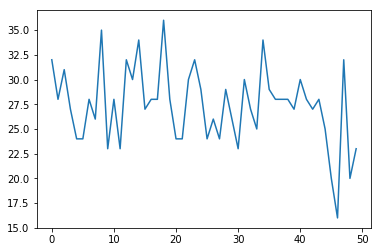

In [15]:
voluspa = []
for paragraph in voluspa_paragraphs:
    if VerseManager.is_fornyrdhislag(paragraph):
        fnl = Fornyrdhislag()
        fnl.from_short_lines_text(paragraph)
        voluspa.append(fnl)
    elif VerseManager.is_ljoodhhaattr(paragraph):
        lh = Ljoodhhaattr()
        lh.from_short_lines_text(paragraph)
        voluspa.append(lh)
        
number_stanzas = len(voluspa)
print("Number of stanzas:", number_stanzas)
number_long_lines = sum([len(meter.long_lines) for meter in voluspa])
print("Number of long lines:", number_long_lines)
number_short_lines = sum([len(meter.short_lines) for meter in voluspa])
print("Number of short lines:", number_short_lines)
number_words = sum([len(short_line.tokenized_text) for meter in voluspa for short_line in meter.short_lines])
print("Number of words:", number_words)
word_number_per_stanza = [sum([len(short_line.tokenized_text) for short_line in meter.short_lines]) for meter in voluspa ]
plt.plot(word_number_per_stanza)

Text(0.5,1,'Comparison')

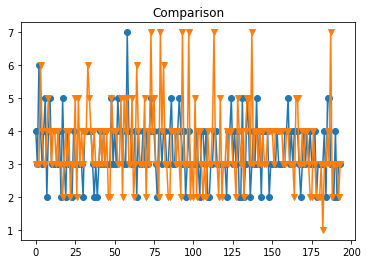

In [16]:
x = np.arange(number_long_lines-6)  # np.linspace(0, number_long_lines, 1)
p1 = plt.plot(x, ([len(long_line[0].tokenized_text) for meter in voluspa for long_line in meter.long_lines if len(long_line) >= 2]), marker="o")
p2 = plt.plot(x, ([len(long_line[1].tokenized_text) for meter in voluspa for long_line in meter.long_lines if len(long_line) >= 2]), marker="v")
plt.title("Comparison")

# number of alliterations from the first shor line of a long line 
# number of alliterations from the second shor line of a long line

Sources :
* [Heimskringla](heimskringla.no)

#### TODO
* Give distributions of syllables per short lines, long lines and stanzas.
* Give distributions of alliterations 
* Number of short lines
* Number of long lines
* Number of stanzas
* Give distribution of unigrams, bigrams
* Give the part of speech of a word
* Apply the same thing to an other eddic poem.


By Clément Besnier, email address: clemsciences@aol.com, web site: https://clementbesnier.pythonanywhere.com/, twitter: clemsciences